# Power Grid Analysis
Data was obtained from MassGIS () and from the  [US Energy Information Administration](https://www.eia.gov/maps/layer_info-m.php)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import shapefile
from dbfread import DBF
from shapely.geometry import Polygon

In [2]:
from pyproj import CRS, Proj, transform, Transformer

In [3]:
def dist(point1, point2):
    return np.sqrt(np.sum((np.array(point2)-np.array(point1))**2))

In [4]:
# Return polygons 
def find_polygons(shape):
    part_boundaries = shape.parts
    part_boundaries.append(len(shape.points)-1)
    part_boundaries = list(set(part_boundaries))
    part_boundaries.sort()
#     part_boundaries = list(set(part_boundaries))
    return [Polygon(shape.points[i:j]) for i,j in zip(part_boundaries[:-1], part_boundaries[1:])]

In [56]:
with open("./datasets/rstd20191209/TRANSLINES_ARC.prj") as f:
    translines_prj = f.readlines()[0]
transformer = Transformer.from_proj(translines_prj,"epsg:4326", always_xy=True)

# Return polygons, in lat/long coords, from MASSGIS (ergo the transformer is instantiated)
def find_and_convert_polygons(shape):
    morph = transformer.transform
    
    part_boundaries = shape.parts
    part_boundaries.append(len(shape.points)-1)
    part_boundaries = list(set(part_boundaries))
    part_boundaries.sort()
    return [Polygon([morph(*point) for point in shape.points[i:j]]) for i,j in zip(part_boundaries[:-1], part_boundaries[1:])]

## Massachusetts state boundaries

In [6]:
mass_metadata = pd.DataFrame(DBF("./datasets/outlin/outlinp1.dbf"))
mass_metadata.sort_values(by="AREA", ascending=False)

,AREA,PERIMETER,OUTLINE_,OUTLINE_ID,AREA_ACRES
0,1.944454e+10,1882711.375,2,1,4804849.1
109,1.021977e+09,735015.375,111,108,252538.6
210,2.445100e+08,196190.922,212,209,60421.8
221,1.213071e+08,114577.555,223,226,29976.2
22,4.795152e+07,65321.559,24,23,11849.1
...,...,...,...,...,...
100,3.104593e+03,230.274,102,99,0.8
67,2.645193e+03,241.657,69,67,0.7
104,2.573186e+03,208.219,106,103,0.6
99,2.011757e+03,173.620,101,98,0.5


In [7]:
with shapefile.Reader("./datasets/outlin/outlinp1.shp") as mass:
    mass_shapes = mass.shapes()

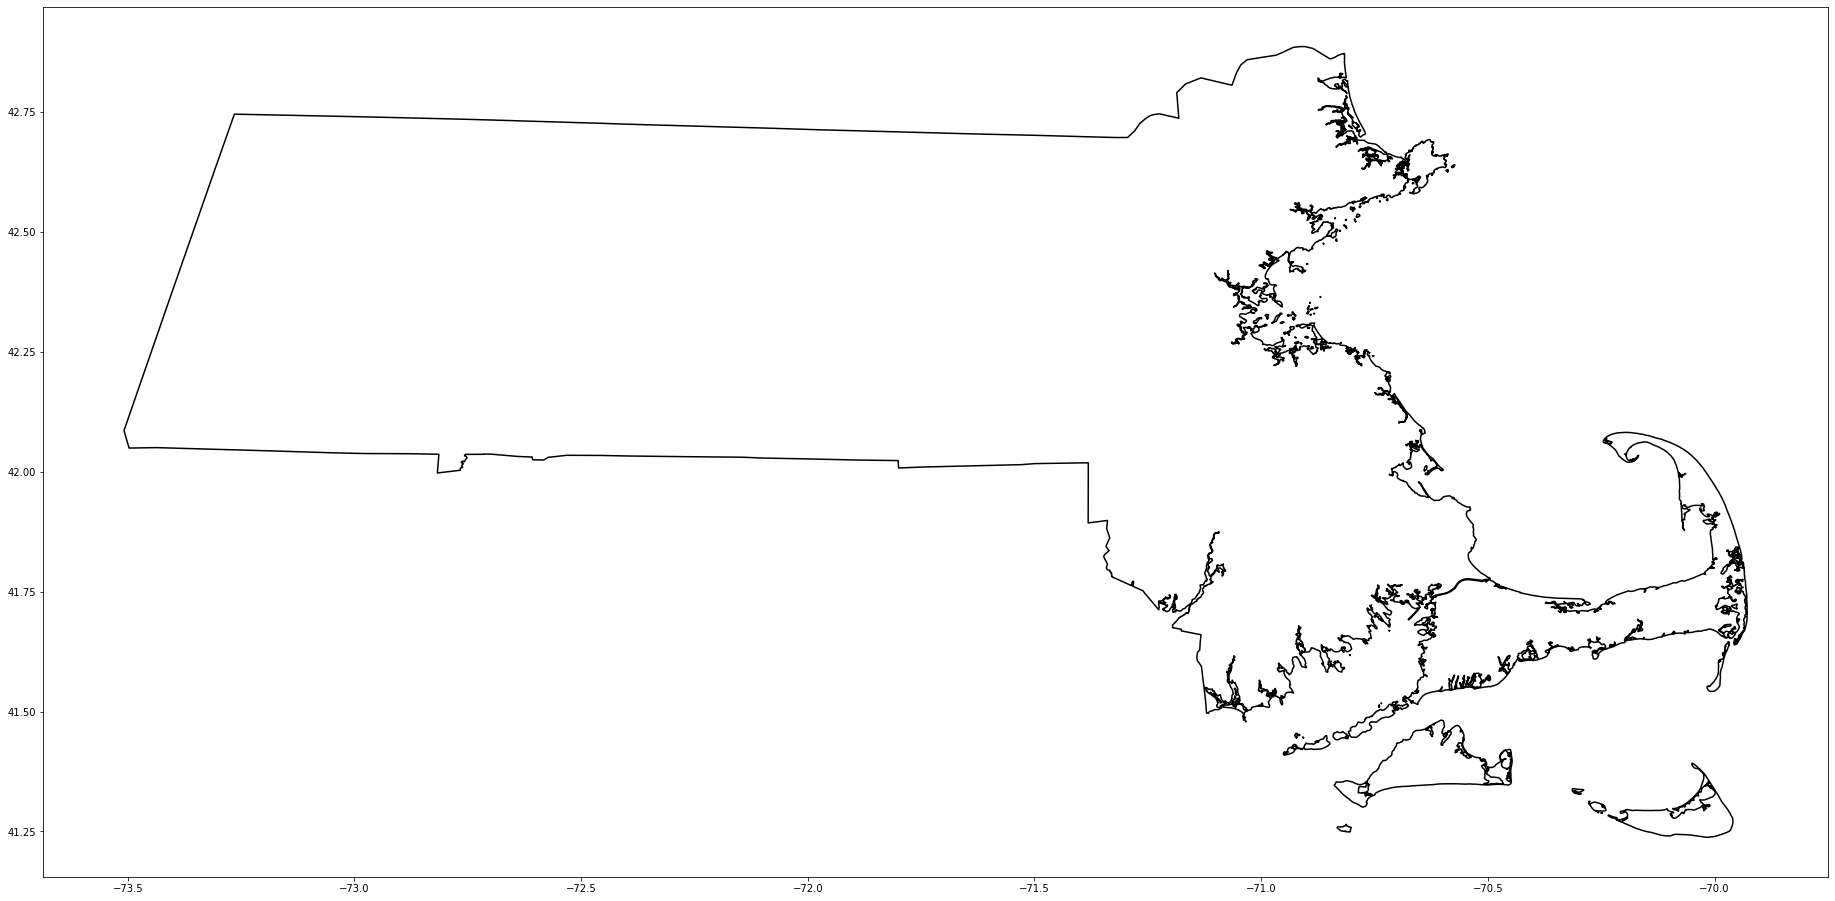

In [8]:
# Plot all of MA
plt.figure(figsize=(32,16))
for shape in mass_shapes:
#     print(shape)
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black')

## Massachusetts Zip Codes

In [9]:
zip_metadata = pd.DataFrame(DBF("datasets/zipcodes_nt/ZIPCODES_NT_POLY.dbf"))

In [10]:
zip_metadata

,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY,AREA_SQMI,SHAPE_AREA,SHAPE_LEN
0,01331,ATHOL,NON UNIQUE,ATHOL,02515,"ATHOL, TOWN OF",WORCESTER,58.084870,1.504391e+08,66459.581259
1,01085,WESTFIELD,NON UNIQUE,WESTFIELD,76030,WESTFIELD,HAMPDEN,55.938928,1.448812e+08,61329.577100
2,01370,SHELBURNE FALLS,NON UNIQUE,SHELBURNE FALLS,61205,"SHELBURNE, TOWN OF",FRANKLIN,48.804057,1.264019e+08,70885.011312
3,01235,HINSDALE,NON UNIQUE,HINSDALE,30280,"HINSDALE, TOWN OF",BERKSHIRE,47.757052,1.236902e+08,49286.404925
4,02747,NORTH DARTMOUTH,NON UNIQUE,NORTH DARTMOUTH,47450,"DARTMOUTH, TOWN OF",BRISTOL,47.495414,1.230126e+08,66614.835420
...,...,...,...,...,...,...,...,...,...,...
544,01107,SPRINGFIELD,NON UNIQUE,SPRINGFIELD,67000,SPRINGFIELD,HAMPDEN,1.498634,3.881445e+06,10376.718676
545,02143,SOMERVILLE,NON UNIQUE,SOMERVILLE,62535,SOMERVILLE,MIDDLESEX,1.496683,3.876392e+06,10257.447499
546,02126,MATTAPAN,NON UNIQUE,MATTAPAN,07000,BOSTON,SUFFOLK,1.913063,4.954811e+06,11393.855139
547,02723,FALL RIVER,NON UNIQUE,FALL RIVER,23000,FALL RIVER,BRISTOL,1.848472,4.787521e+06,10099.578308


In [11]:
len(zip_metadata)

549

In [12]:
with shapefile.Reader("./datasets/zipcodes_nt/ZIPCODES_NT_POLY.shp") as zipshape:
    zip_shapes = zipshape.shapes()
len(zip_shapes)

549

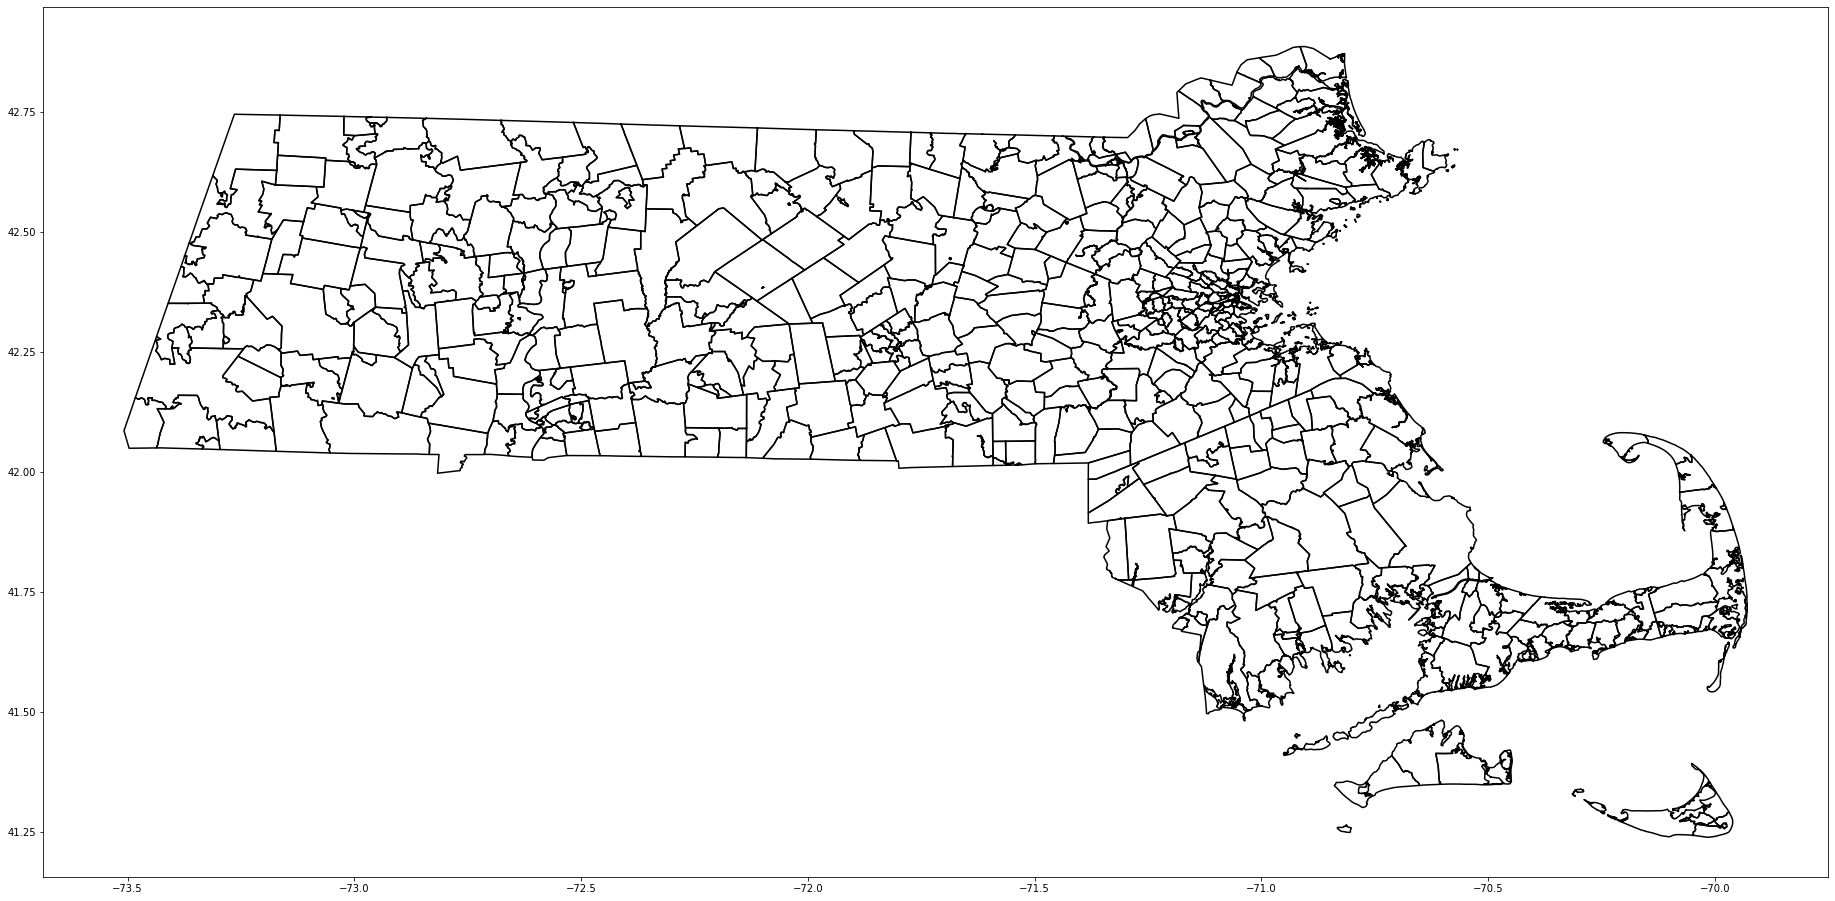

In [13]:
plt.figure(figsize=(32,16))
for shape in zip_shapes:
#     print(shape)
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black')

## MASSGIS Power lines 

In [14]:
metadata = pd.DataFrame(DBF("datasets/rstd20191209/TRANSLINES_ARC.dbf"))

In [15]:
metadata.dtypes

OBJECTID       int64
MINOR_TOT     object
MINOR_NUM      int64
SOURCE        object
SHAPE_LEN    float64
dtype: object

In [16]:
metadata["MINOR_TOT"].value_counts()

   202    486
   403    155
   401    106
   201     96
202205     20
   204     14
201205     10
Name: MINOR_TOT, dtype: int64

In [17]:
metadata["MINOR_NUM"].value_counts()

202       486
403       155
401       106
201        96
202205     20
204        14
201205     10
Name: MINOR_NUM, dtype: int64

In [18]:
with shapefile.Reader("./datasets/rstd20191209/TRANSLINES_ARC.shp") as shp:
    power_shapes = shp.shapes()

(-73.68726144993803, -69.74877976251268)
(41.15551887575295, 42.96926109623473)


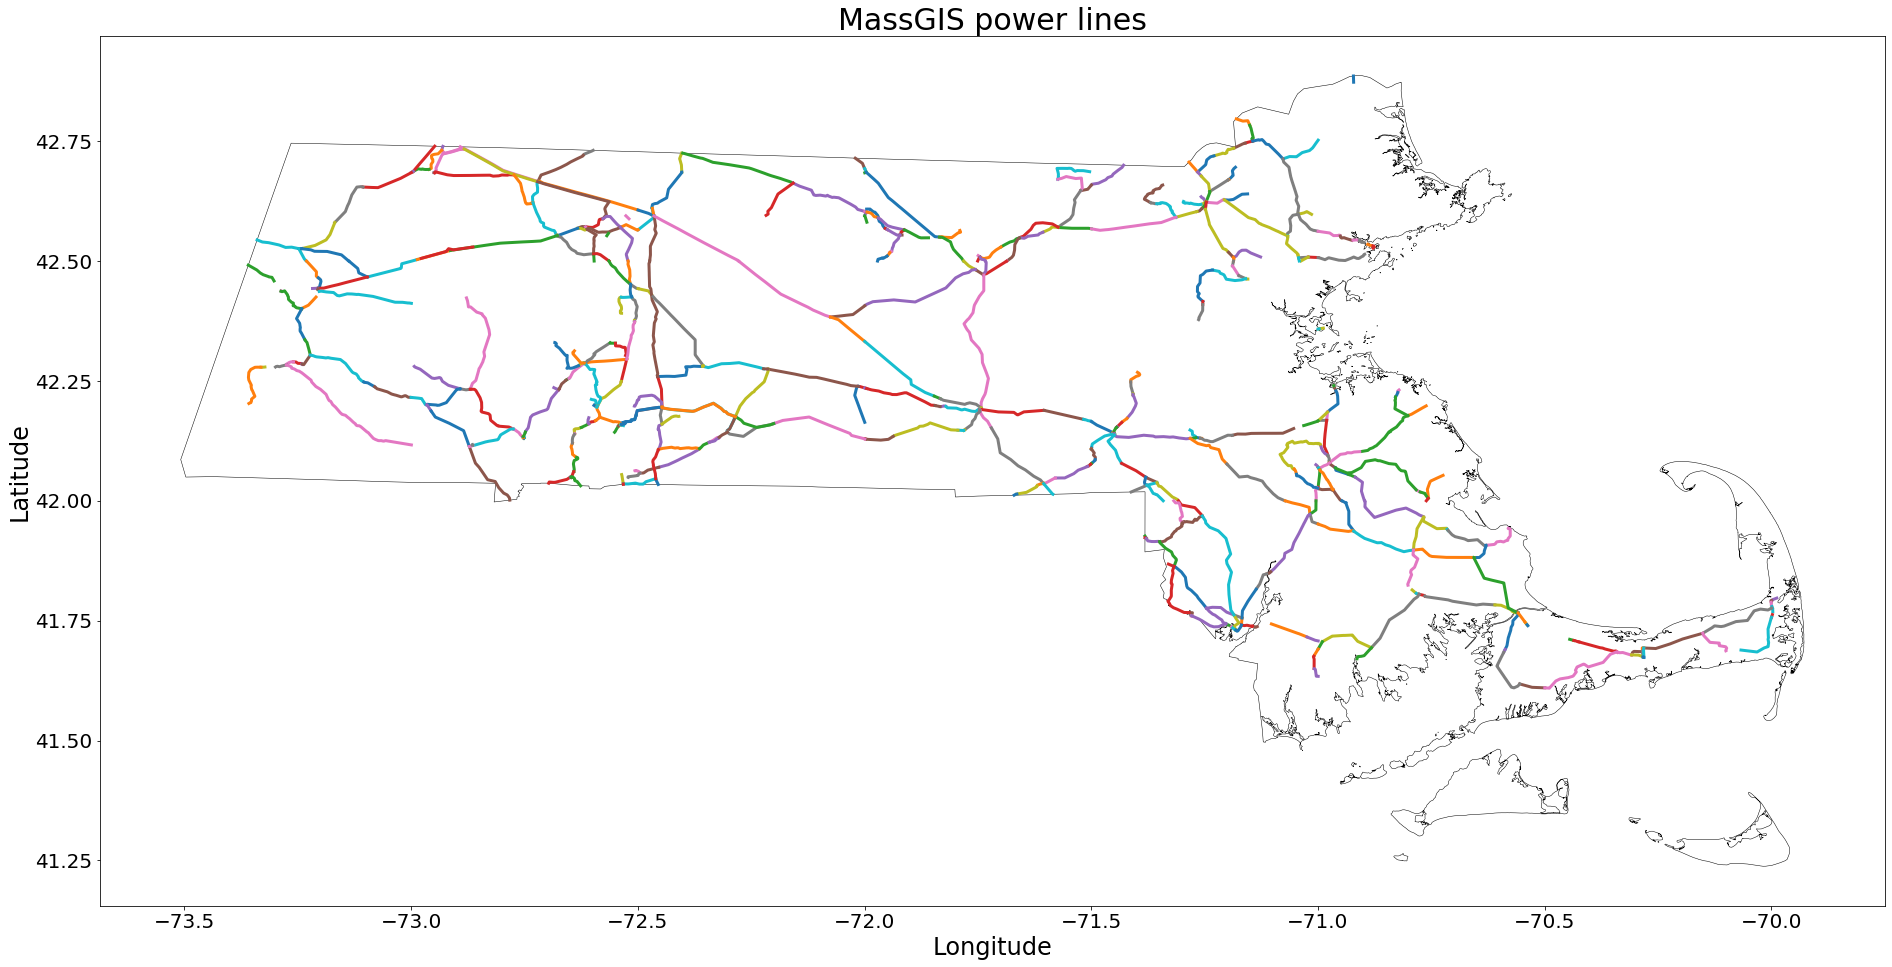

In [188]:
plt.figure(figsize=(32,16))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=0.5)
for shape, attr in zip(power_shapes, metadata["MINOR_NUM"]):
    if attr in [202, 202205]:
        plt.plot(*zip(*[transformer.transform(*point) for point in shape.points]), linewidth=3)
print(plt.xlim())
print(plt.ylim())
plt.title("MassGIS power lines", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/massgis_power.png", bbox_inches="tight")

# EIA data
We have three new datasets: Power plants, electric substations, and transmission power lines.

## Power lines

In [72]:
power_line_df = pd.DataFrame(DBF("./datasets/eia/Electric_Power_Transmission_Lines/Electric_Power_Transmission_Lines.dbf"))

In [74]:
power_line_df.head()

,OBJECTID,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len
0,1,140809,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2014-04-16T00:00:00.000Z,IMAGERY,2017-02-15T00:00:00.000Z,NOT AVAILABLE,161.0,100-161,Y,PHILLIPS BEND,JOHN SEVIER,24018.513114
1,2,140837,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, https://www9.nationalgridus.com/oasis...",2015-06-16T00:00:00.000Z,IMAGERY,2019-03-05T00:00:00.000Z,NOT AVAILABLE,115.0,100-161,Y,TAP140359,TAP140373,5972.919614
2,3,140811,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2014-06-20T00:00:00.000Z,IMAGERY,2017-03-20T00:00:00.000Z,NOT AVAILABLE,115.0,100-161,Y,GENTILLY ROAD,MICHOUD STATION,14253.092823
3,4,140813,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-10-04T00:00:00.000Z,IMAGERY/OTHER,2018-05-09T00:00:00.000Z,NOT AVAILABLE,161.0,100-161,Y,UNKNOWN137689,TAP137690,8950.844317
4,5,140814,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-06-23T00:00:00.000Z,IMAGERY,2014-06-23T00:00:00.000Z,ALABAMA POWER CO,-999999.0,100-161,Y,UNKNOWN112122,UNKNOWN112349,5339.587603


In [73]:
power_line_df.shape

(83207, 17)

In [20]:
power_line_df["VOLTAGE"].value_counts()

-999999.00    23464
 115.00       15031
 138.00       10684
 69.00         8022
 230.00        6233
 161.00        3172
 345.00        2171
 100.00        1595
 66.00         1352
 60.00          985
 500.00         732
 46.00          221
 120.00         190
 34.50          154
 70.00          101
 92.00           83
 57.00           73
 33.00           58
 765.00          42
 38.00           28
 13.80           22
 34.00           18
 55.00           18
 57.10           15
 220.00          12
 128.00           9
 110.00           8
 12.00            5
 12.46            5
 240.00           4
 287.00           3
 24.90            3
 25.00            3
 12.70            3
 135.00           3
 12.50            2
 450.00           2
 13.20            2
 250.00           2
 400.00           2
 200.00           2
 3.00             2
 32.30            1
 50.00            1
 72.00            1
 155.00           1
 114.00           1
 2.50             1
 43.80            1
 45.00            1


In [21]:
with shapefile.Reader("./datasets/eia/Electric_Power_Transmission_Lines/Electric_Power_Transmission_Lines.shp") as shp:
    eia_power_shapes = shp.shapes()

In [28]:
with open("./datasets/eia/Electric_Power_Transmission_Lines/Electric_Power_Transmission_Lines.prj") as f:
    translines_eia_prj = f.readlines()[0]
transformer_eia_power = Transformer.from_proj(translines_eia_prj,"epsg:4326", always_xy=True)

We want to select only power lines remotely near Massachusetts. From above, the bounding box of our canvas was

(-73.68726144993803, -69.74877976251268)


(41.15551887575295, 42.96926109623473)
Since our box is fairly wide relative to Massachusetts, it should be sufficient to filter by the first point.

In [123]:
# Returns whether or not a set of latitude/longitude are roughly in Massachusetts
def in_mass(long, lat):
    # First check to see if we're in the bounding box
    if (-73.687 < long < -69.749) and (41.156 < lat < 42.969):
        # Then exclude the large chunks of CT and RI
#         return True
        return not ((lat < 41.75) and (long < -71.8))

In [124]:
# Save the indices of all shapes in eia_power_shapes
mass_indices = [i for i,j in enumerate(eia_power_shapes) if in_mass(*transformer_eia_power.transform(*j.points[0])) and in_mass(*transformer_eia_power.transform(*j.points[-1]))]

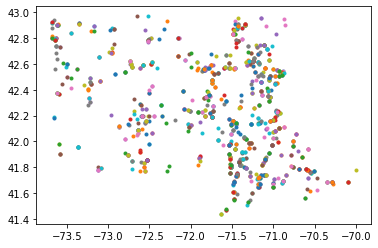

In [125]:
# Exploratory plot to verify that we're on-target
for i, shape in enumerate(eia_power_shapes):
    if i in mass_indices:
        plt.plot(*transformer_eia_power.transform(*shape.points[0]),'.')

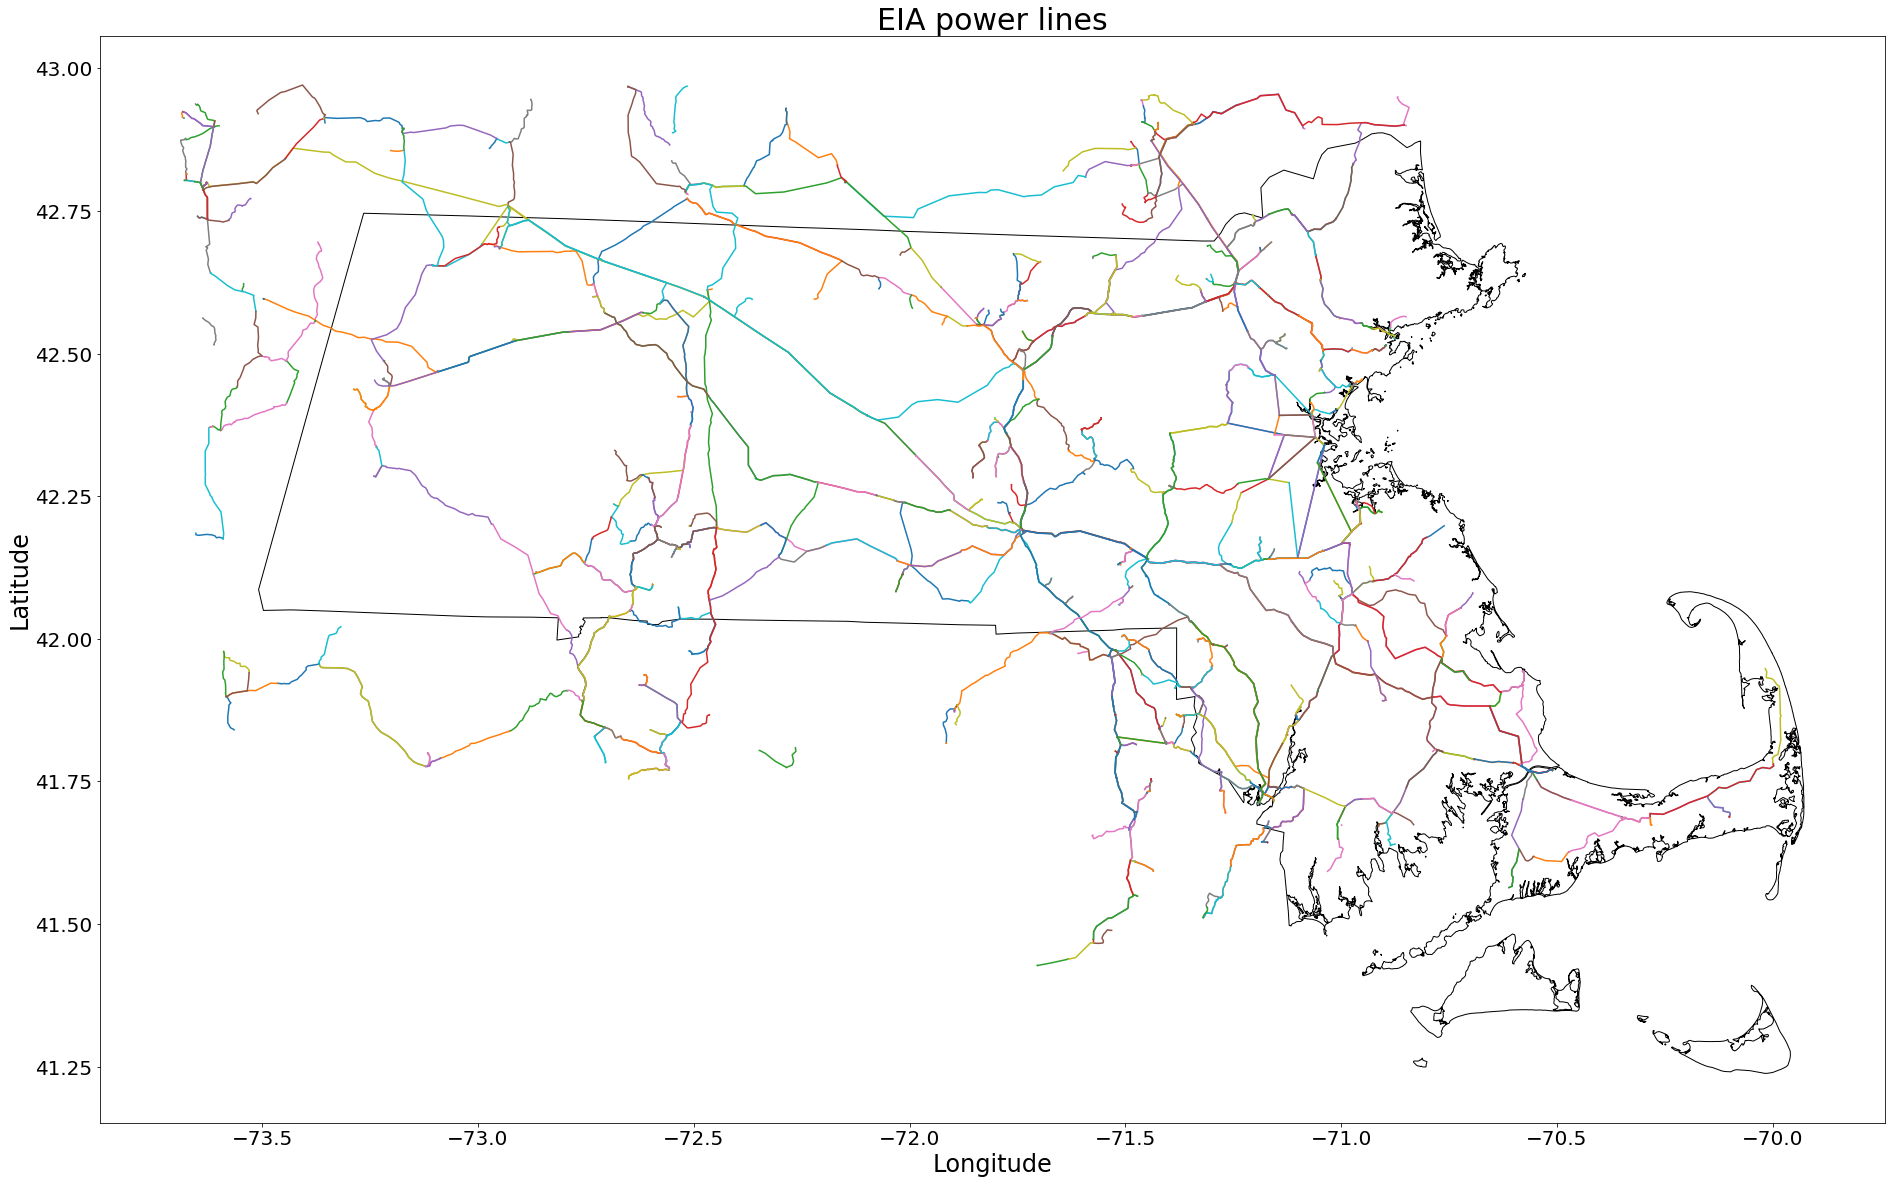

In [189]:
# Full powerline plot
plt.figure(figsize=(32,20))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=1)
for i, shape in enumerate(eia_power_shapes):
    if i in mass_indices:
        plt.plot(*zip(*[transformer_eia_power.transform(*point) for point in shape.points]))
#         plt.plot(*transformer_eia_power.transform(*shape.points[0]),'.')
plt.title("EIA power lines", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/eia_power.png", bbox_inches="tight")

In [68]:
len(eia_power_shapes)

83207

In [77]:
# See what the voltages of the plotted lines are
power_line_df.iloc[mass_indices]["VOLTAGE"].value_counts()

 115.0       1078
-999999.0     173
 345.0        146
 69.0          48
 230.0         27
 155.0          1
 450.0          1
Name: VOLTAGE, dtype: int64

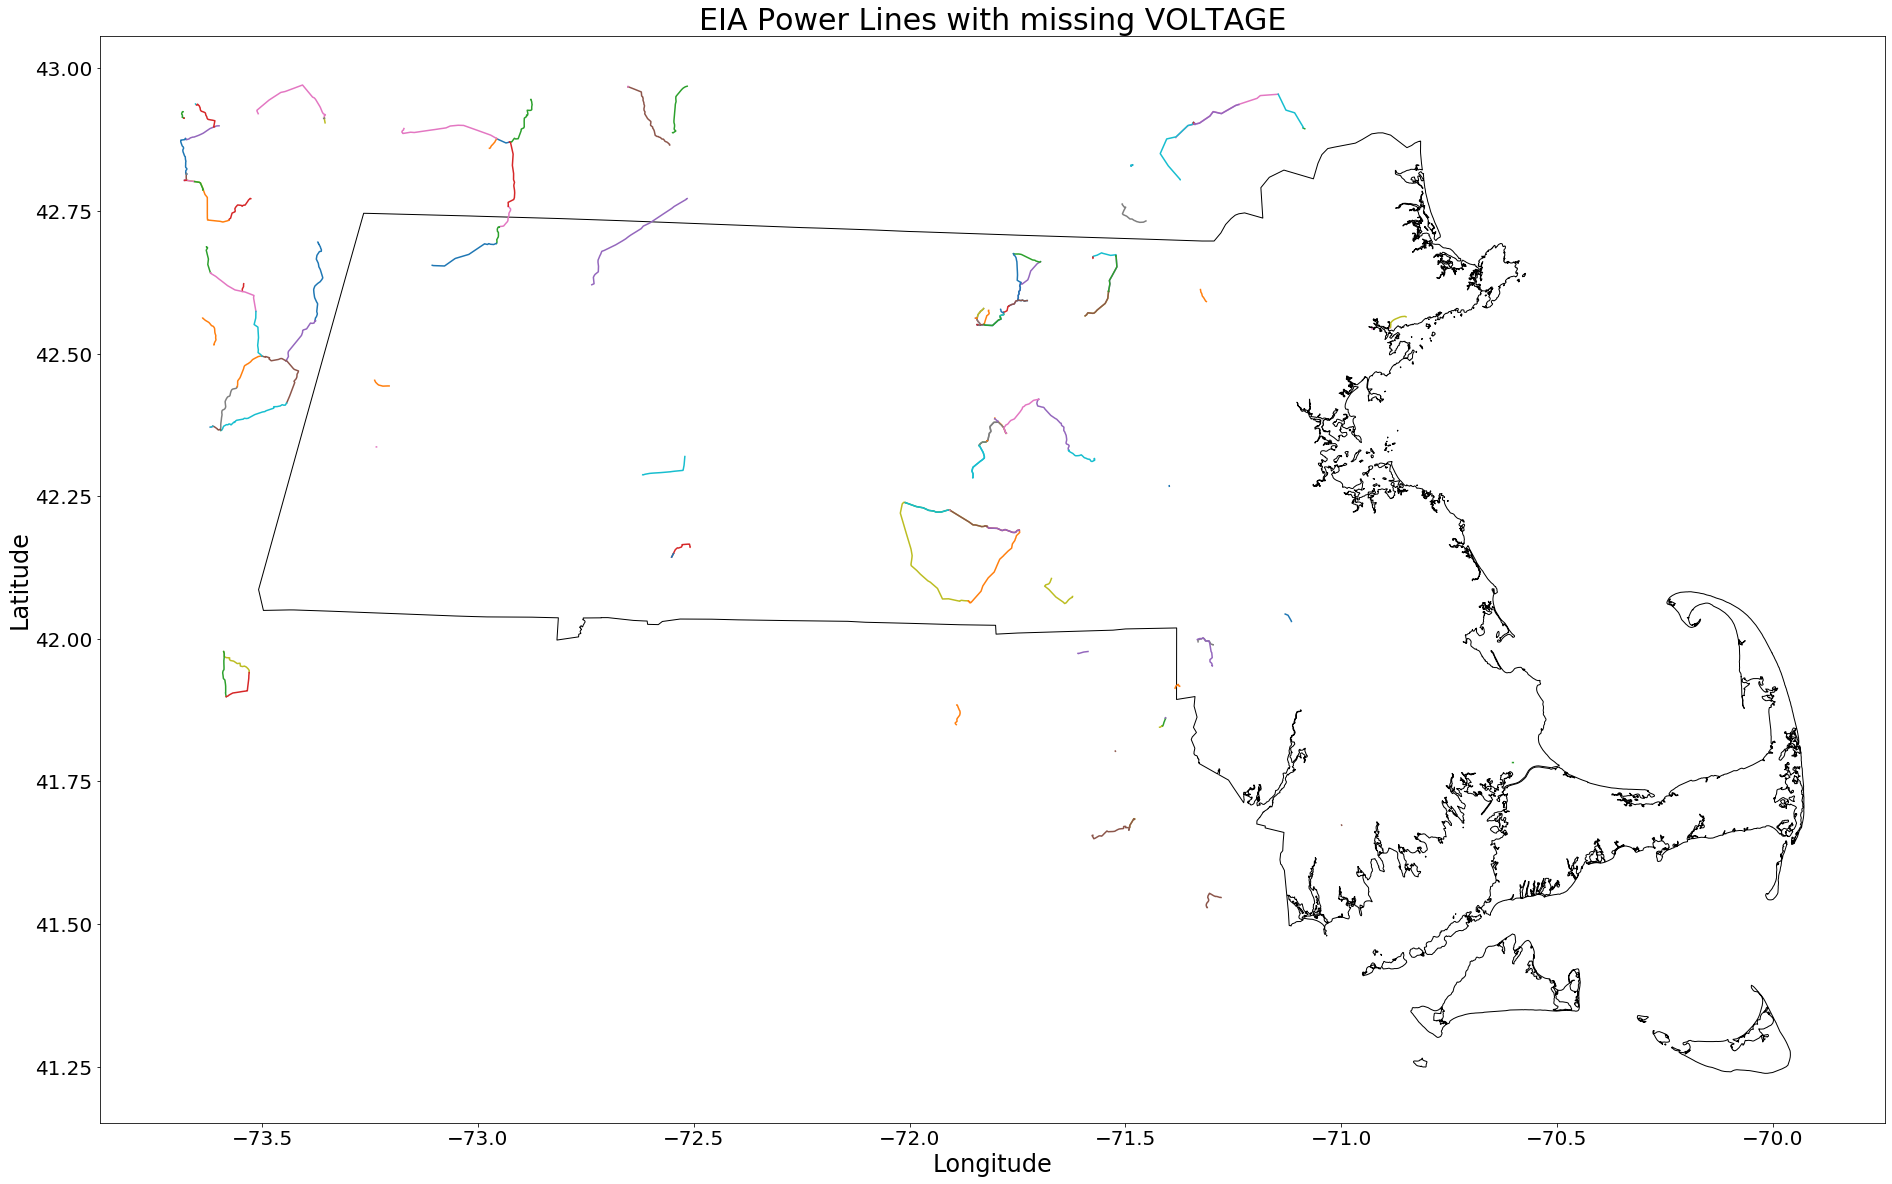

In [190]:
# Visualize the power lines that don't have a voltage
plt.figure(figsize=(32,20))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=1)
for i, shape in enumerate(eia_power_shapes):
    if i in mass_indices and power_line_df.iloc[i]["VOLTAGE"]==-999999:
        plt.plot(*zip(*[transformer_eia_power.transform(*point) for point in shape.points]))
#         plt.plot(*transformer_eia_power.transform(*shape.points[0]),'.')
plt.title("EIA Power Lines with missing VOLTAGE", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/eia_missing_voltage.png", bbox_inches="tight")

## Substations

In [131]:
substation_df = pd.DataFrame(DBF("./datasets/eia/Electric_Substations/Electric_Substations.dbf", encoding="UTF-8"))

In [132]:
substation_df.head()

,OBJECTID,ID,NAME,CITY,STATE,ZIP,TYPE,STATUS,COUNTY,COUNTYFIPS,...,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,LINES,MAX_VOLT,MIN_VOLT,MAX_INFER,MIN_INFER
0,2003,140941,TAP140941,CRANSTON,RI,02921,TAP,IN SERVICE,PROVIDENCE,44007,...,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2015-08-11T00:00:00.000Z,IMAGERY/OTHER,2016-11-18T00:00:00.000Z,3,115.0,115.0,Y,Y
1,2004,156254,TAP156254,PROVIDENCE,RI,02908,TAP,IN SERVICE,PROVIDENCE,44007,...,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-05-01T00:00:00.000Z,IMAGERY,2018-05-01T00:00:00.000Z,3,115.0,115.0,Y,Y
2,2005,156255,TAP156255,PROVIDENCE,RI,02908,TAP,IN SERVICE,PROVIDENCE,44007,...,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-05-01T00:00:00.000Z,IMAGERY,2018-05-01T00:00:00.000Z,3,115.0,115.0,Y,Y
3,2006,136577,TAP136577,ODESSA,RI,79763,TAP,IN SERVICE,WASHINGTON,44009,...,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2015-08-11T00:00:00.000Z,IMAGERY/OTHER,2015-08-14T00:00:00.000Z,3,115.0,115.0,Y,Y
4,2007,140926,TAP140926,NORTH KINGSTOWN TOWN OF,RI,02852,TAP,IN SERVICE,WASHINGTON,44009,...,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2016-08-02T00:00:00.000Z,IMAGERY/OTHER,2016-11-21T00:00:00.000Z,3,115.0,115.0,Y,Y


In [138]:
substation_df.shape

(68991, 24)

In [139]:
substation_df.columns

Index(['OBJECTID', 'ID', 'NAME', 'CITY', 'STATE', 'ZIP', 'TYPE', 'STATUS',
       'COUNTY', 'COUNTYFIPS', 'COUNTRY', 'LATITUDE', 'LONGITUDE',
       'NAICS_CODE', 'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD',
       'VAL_DATE', 'LINES', 'MAX_VOLT', 'MIN_VOLT', 'MAX_INFER', 'MIN_INFER'],
      dtype='object')

In [140]:
substation_df["MAX_VOLT"].value_counts()

-999999.00    18341
 115.00       14951
 69.00        12718
 138.00        9391
 230.00        4358
 161.00        2991
 66.00         1590
 345.00        1558
 100.00         922
 60.00          510
 500.00         475
 46.00          318
 120.00         268
 34.50          217
 70.00           50
 765.00          36
 33.00           36
 38.00           34
 57.00           33
 16.00           24
 34.00           18
 32.00           18
 92.00           17
 12.00           15
 57.10           14
 132.00          13
 128.00           9
 360.00           6
 110.00           6
 287.00           4
 136.00           4
 13.00            3
 250.00           3
 7.50             3
 13.80            3
 24.90            2
 400.00           2
 220.00           2
 88.00            2
 55.00            2
 240.00           2
 200.00           2
 450.00           2
 14.40            2
 275.00           2
 68.00            1
 72.00            1
 45.00            1
 12.70            1
 114.00           1


In [141]:
with shapefile.Reader("./datasets/eia/Electric_Substations/Electric_Substations.shp") as shp:
    eia_substation_shapes = shp.shapes()

In [142]:
with open("./datasets/eia/Electric_Substations/Electric_Substations.prj") as f:
    substations_eia_prj = f.readlines()[0]
transformer_eia_substations = Transformer.from_proj(substations_eia_prj,"epsg:4326", always_xy=True)

In [144]:
# Save the indices of all shapes in eia_substation_shapes
substation_indices = [i for i,j in enumerate(eia_substation_shapes) if in_mass(*transformer_eia_substations.transform(*j.points[0])) and in_mass(*transformer_eia_substations.transform(*j.points[-1]))]

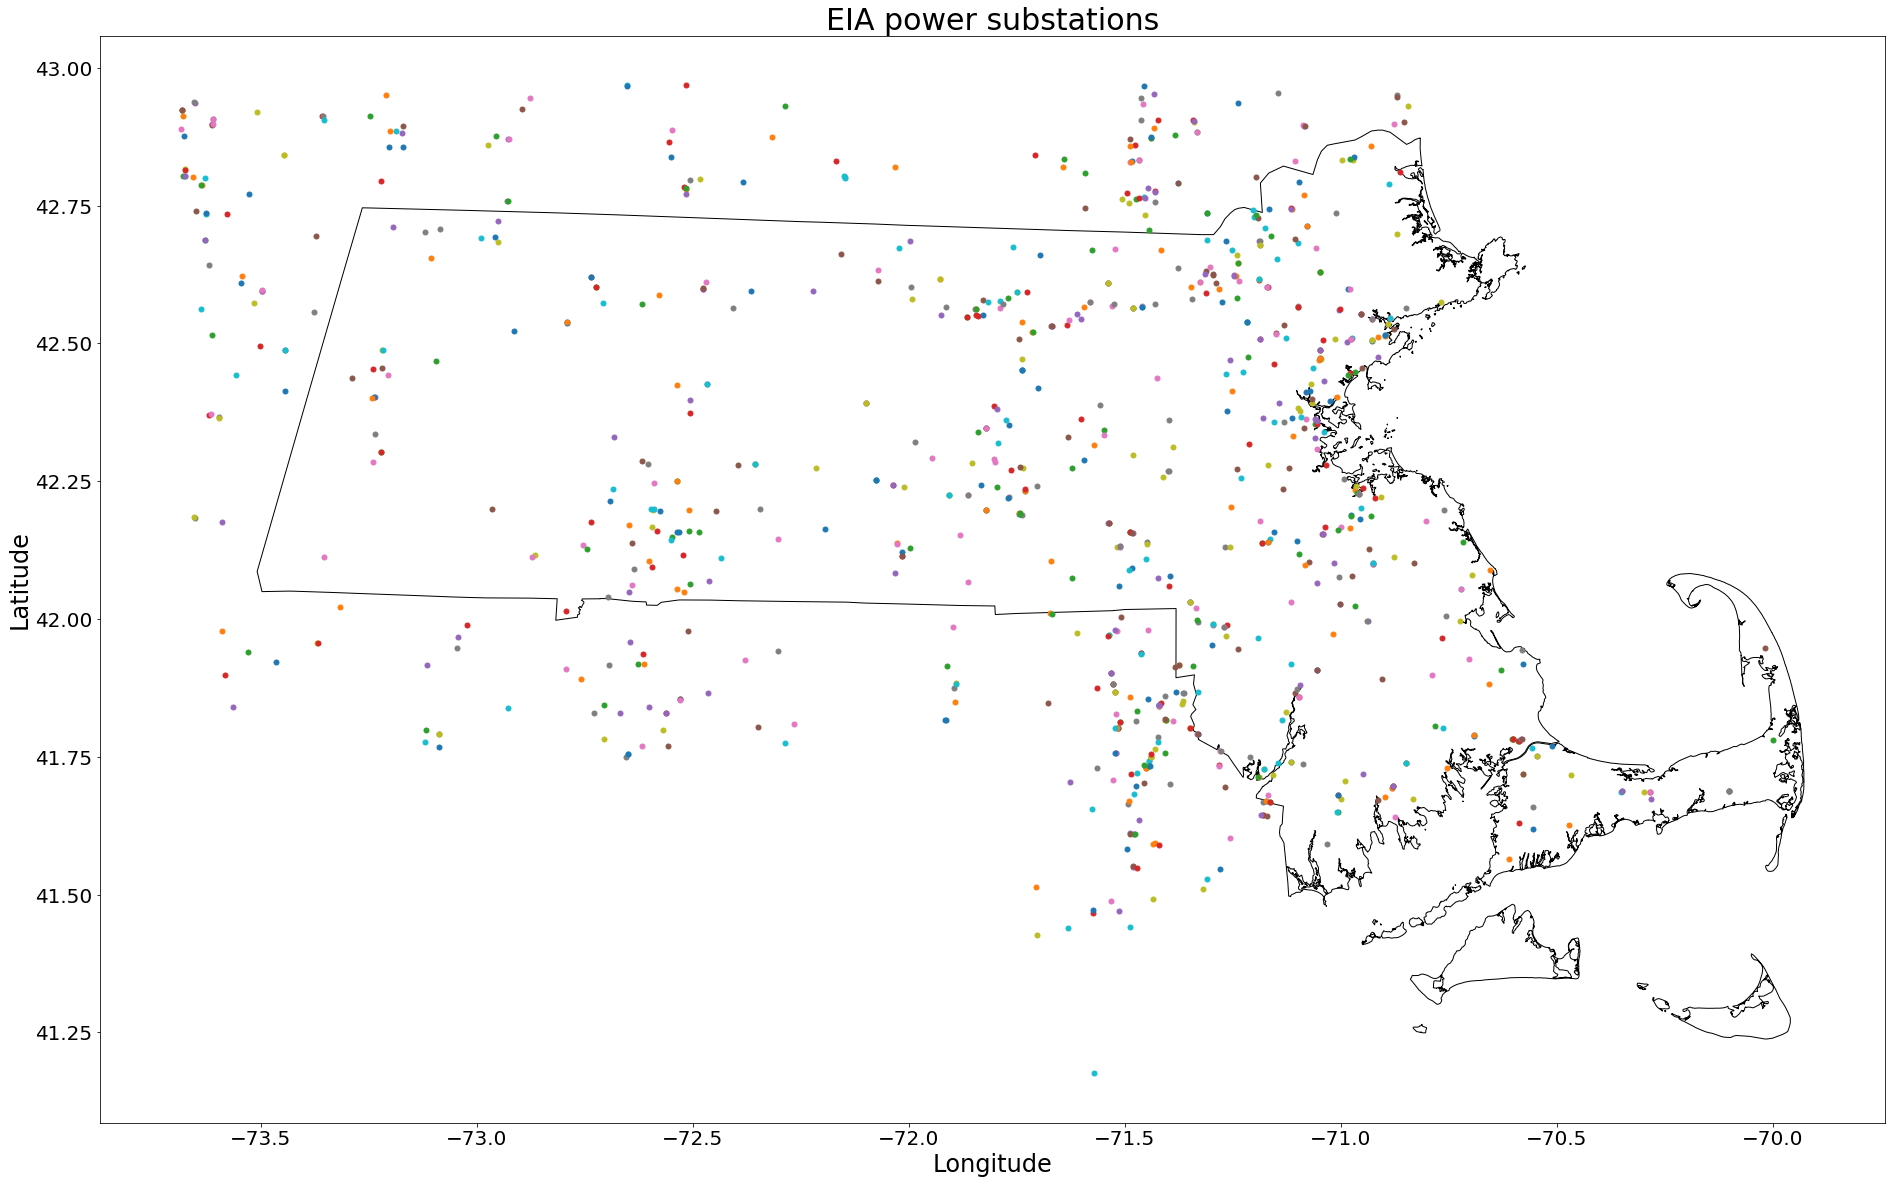

In [191]:
# Plot all the relevant substations
plt.figure(figsize=(32,20))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=1)
for i, shape in enumerate(eia_substation_shapes):
    if i in substation_indices:
        plt.plot(*zip(*[transformer_eia_substations.transform(*point) for point in shape.points]), '.', markersize=10)
#         plt.plot(*transformer_eia_power.transform(*shape.points[0]),'.')
plt.title("EIA power substations", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/eia_substations.png", bbox_inches="tight")

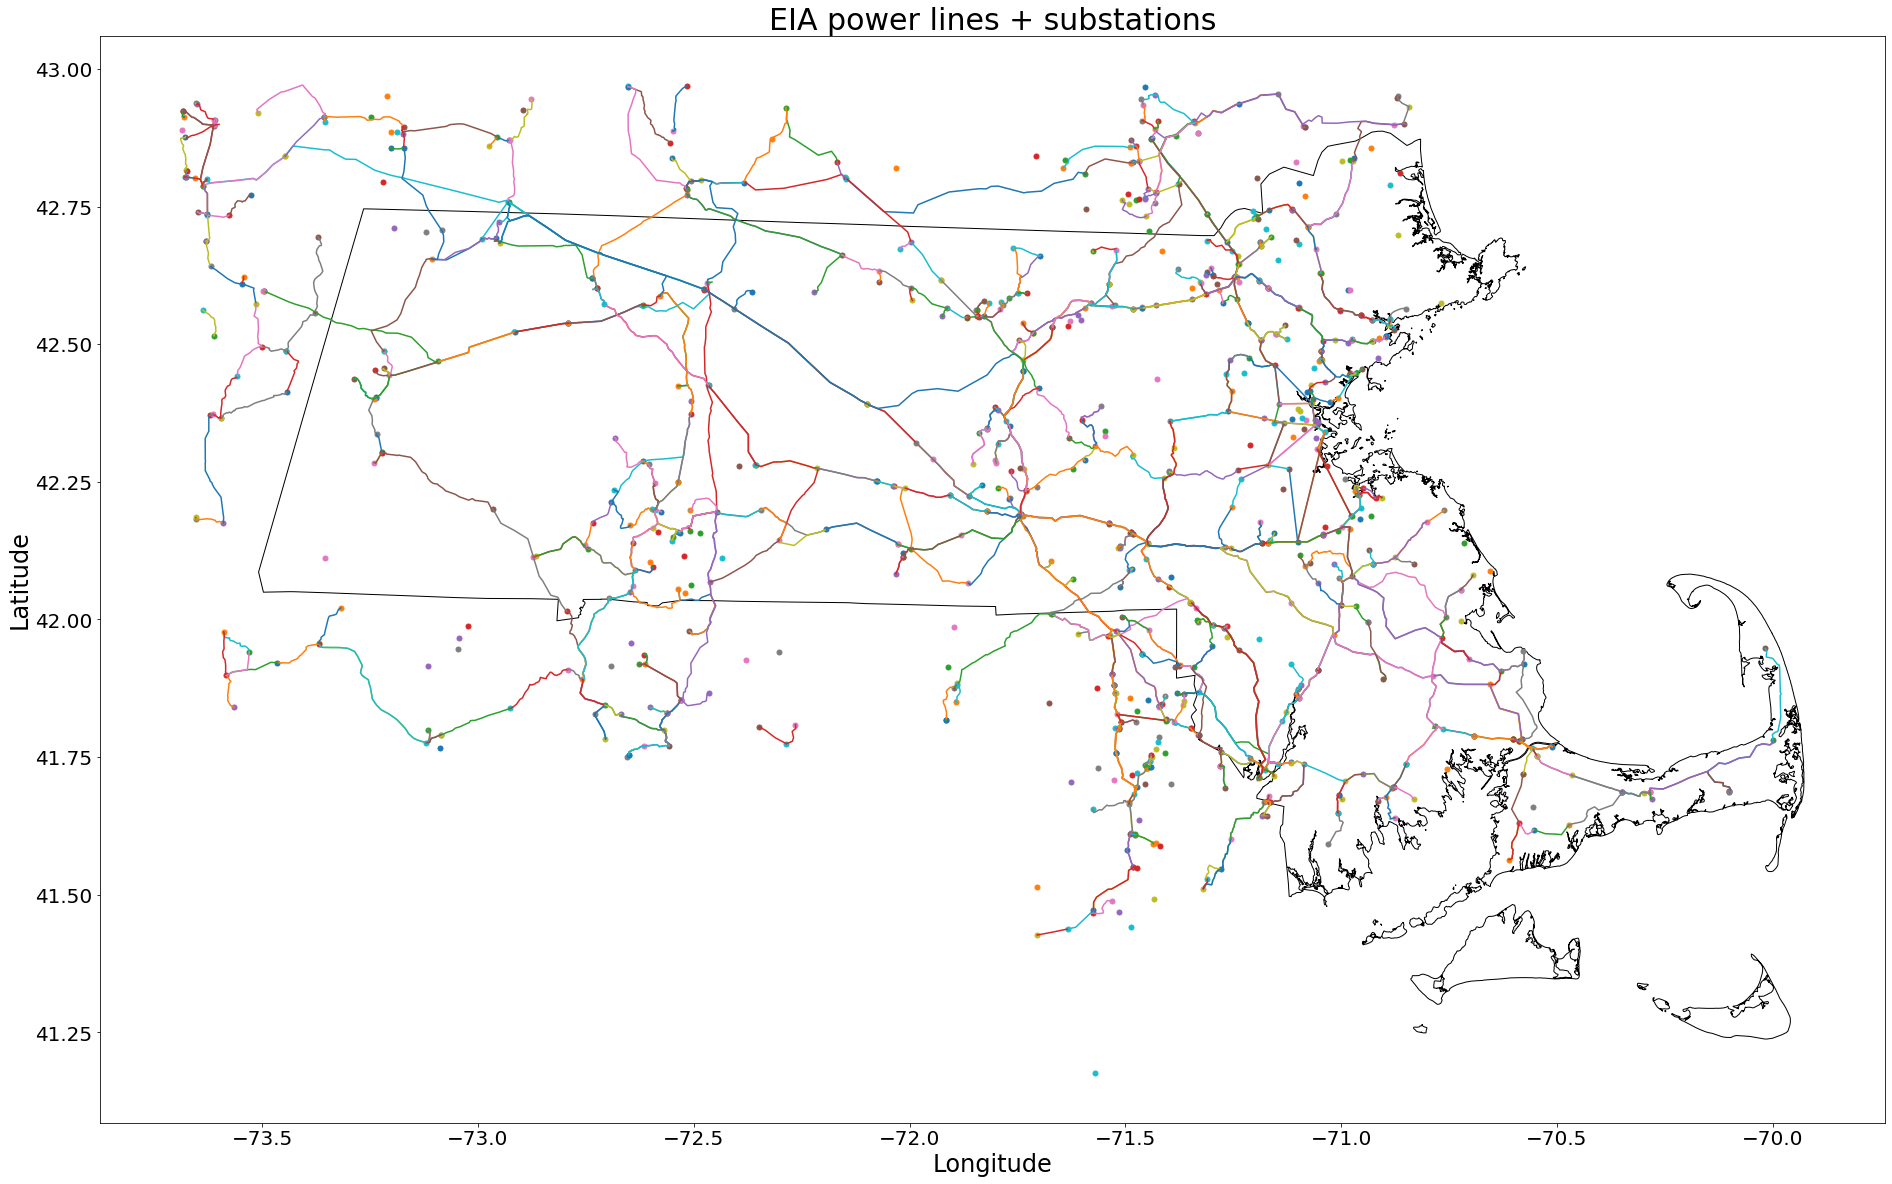

In [192]:
# Plot all the relevant substations with the power lines
plt.figure(figsize=(32,20))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=1)
for i, shape in enumerate(eia_substation_shapes):
    if i in substation_indices:
        plt.plot(*zip(*[transformer_eia_substations.transform(*point) for point in shape.points]), '.', markersize=10)
for i, shape in enumerate(eia_power_shapes):
    if i in mass_indices:
        plt.plot(*zip(*[transformer_eia_power.transform(*point) for point in shape.points]))
plt.title("EIA power lines + substations", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/eia_plines_substations.png", bbox_inches="tight")

## Power plants

In [150]:
plants_df = pd.DataFrame(DBF("./datasets/eia/PowerPlants_US_EIA/PowerPlants_US_201910.dbf", encoding="UTF-8"))

In [151]:
plants_df.head()

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,StateName,Zip,Street_Add,...,Wind_MW,Geo_MW,Bat_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude
0,2,Bankhead Dam,Alabama Power Co,195,Electric Utility,Northport,Tuscaloosa,Alabama,35476,19001 Lock 17 Road,...,0.0,,,,Hydroelectric = 53 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201910,33.458665,-87.356823
1,3,Barry,Alabama Power Co,195,Electric Utility,Bucks,Mobile,Alabama,36512,North Highway 43,...,0.0,,,,"Coal = 1118.5 MW, Natural Gas = 1219.4 MW",Conventional Steam Coal; Natural Gas Fired Com...,"EIA-860, EIA-860M and EIA-923",201910,31.006900,-88.010300
2,4,Walter Bouldin Dam,Alabama Power Co,195,Electric Utility,Wetumpka,Elmore,Alabama,36092,750 Bouldin Dam Road,...,0.0,,,,Hydroelectric = 224.1 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201910,32.583889,-86.283056
3,7,Gadsden,Alabama Power Co,195,Electric Utility,Gadsden,Etowah,Alabama,35903,1000 Goodyear Ave,...,0.0,,,,Natural Gas = 130 MW,Natural Gas Steam Turbine,"EIA-860, EIA-860M and EIA-923",201910,34.012800,-85.970800
4,9,Copper,El Paso Electric Co,5701,Electric Utility,El Paso,El Paso,Texas,79915,651 Hawkins Blvd.,...,0.0,,,,Natural Gas = 64 MW,Natural Gas Fired Combustion Turbine,"EIA-860, EIA-860M and EIA-923",201910,31.756900,-106.375000


In [152]:
plants_df.shape

(9546, 31)

In [153]:
plants_df.columns

Index(['Plant_Code', 'Plant_Name', 'Utility_Na', 'Utility_ID', 'sector_nam',
       'City', 'County', 'StateName', 'Zip', 'Street_Add', 'PrimSource',
       'Install_MW', 'Total_MW', 'Coal_MW', 'NG_MW', 'Crude_MW', 'Bio_MW',
       'Hydro_MW', 'HydroPS_MW', 'Nuclear_MW', 'Solar_MW', 'Wind_MW', 'Geo_MW',
       'Bat_MW', 'Other_MW', 'source_des', 'tech_desc', 'Source', 'Period',
       'Latitude', 'Longitude'],
      dtype='object')

In [157]:
plants_df["Total_MW"].value_counts()

1.0       441
5.0       427
2.0       411
3.0       244
1.5       241
         ... 
37.9        1
1854.0      1
369.0       1
327.0       1
2363.4      1
Name: Total_MW, Length: 1941, dtype: int64

In [158]:
with shapefile.Reader("./datasets/eia/PowerPlants_US_EIA/PowerPlants_US_201910.shp") as shp:
    eia_plant_shapes = shp.shapes()

In [159]:
with open("./datasets/eia/PowerPlants_US_EIA/PowerPlants_US_201910.prj") as f:
    plants_eia_prj = f.readlines()[0]
transformer_eia_plants = Transformer.from_proj(plants_eia_prj,"epsg:4326", always_xy=True)

In [160]:
# Save the indices of all shapes in eia_plant_shapes
plant_indices = [i for i,j in enumerate(eia_plant_shapes) if in_mass(*transformer_eia_plants.transform(*j.points[0])) and in_mass(*transformer_eia_plants.transform(*j.points[-1]))]

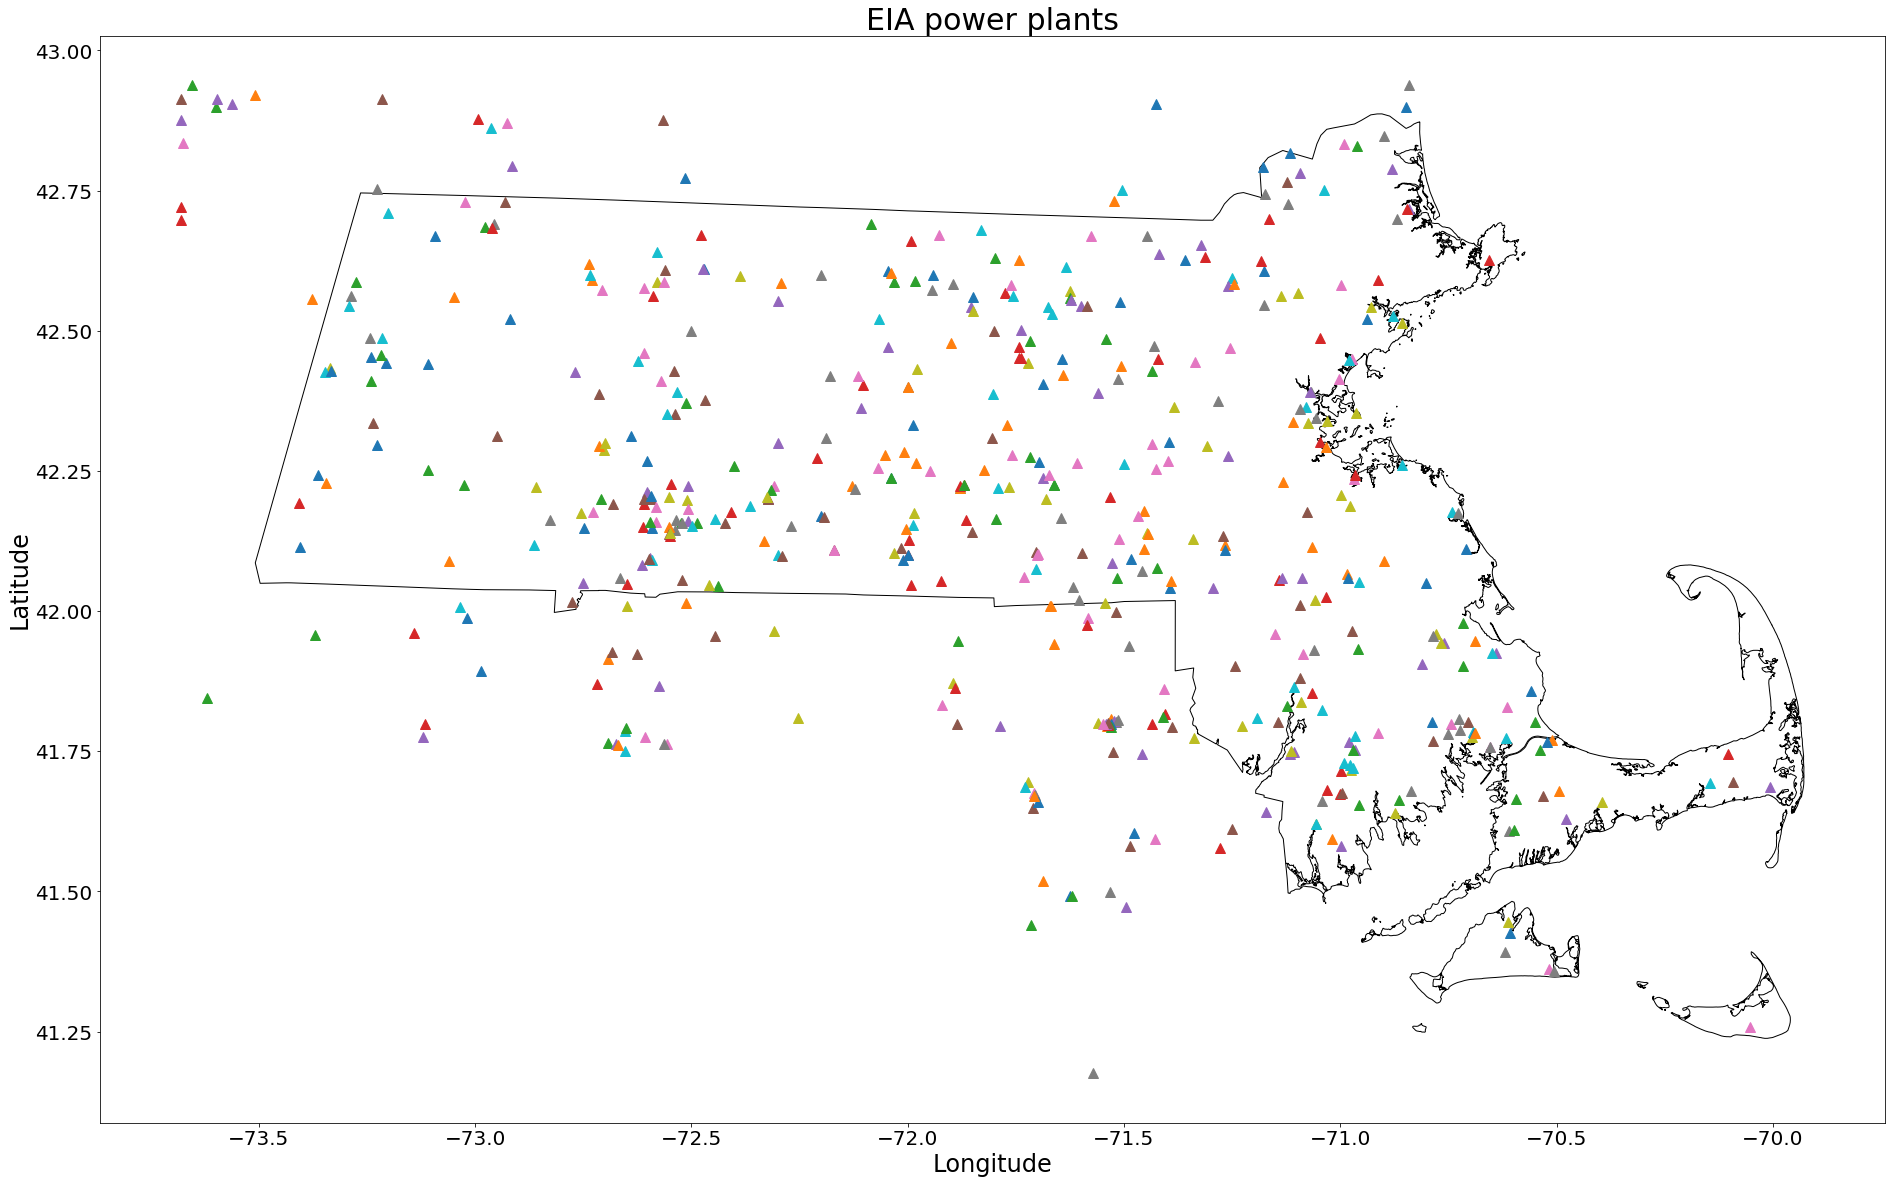

In [193]:
# Plot all the relevant plants
plt.figure(figsize=(32,20))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=1)
for i, shape in enumerate(eia_plant_shapes):
    if i in plant_indices:
        plt.plot(*zip(*[transformer_eia_plants.transform(*point) for point in shape.points]), '^', markersize=10)
plt.title("EIA power plants", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/eia_plants.png", bbox_inches="tight")

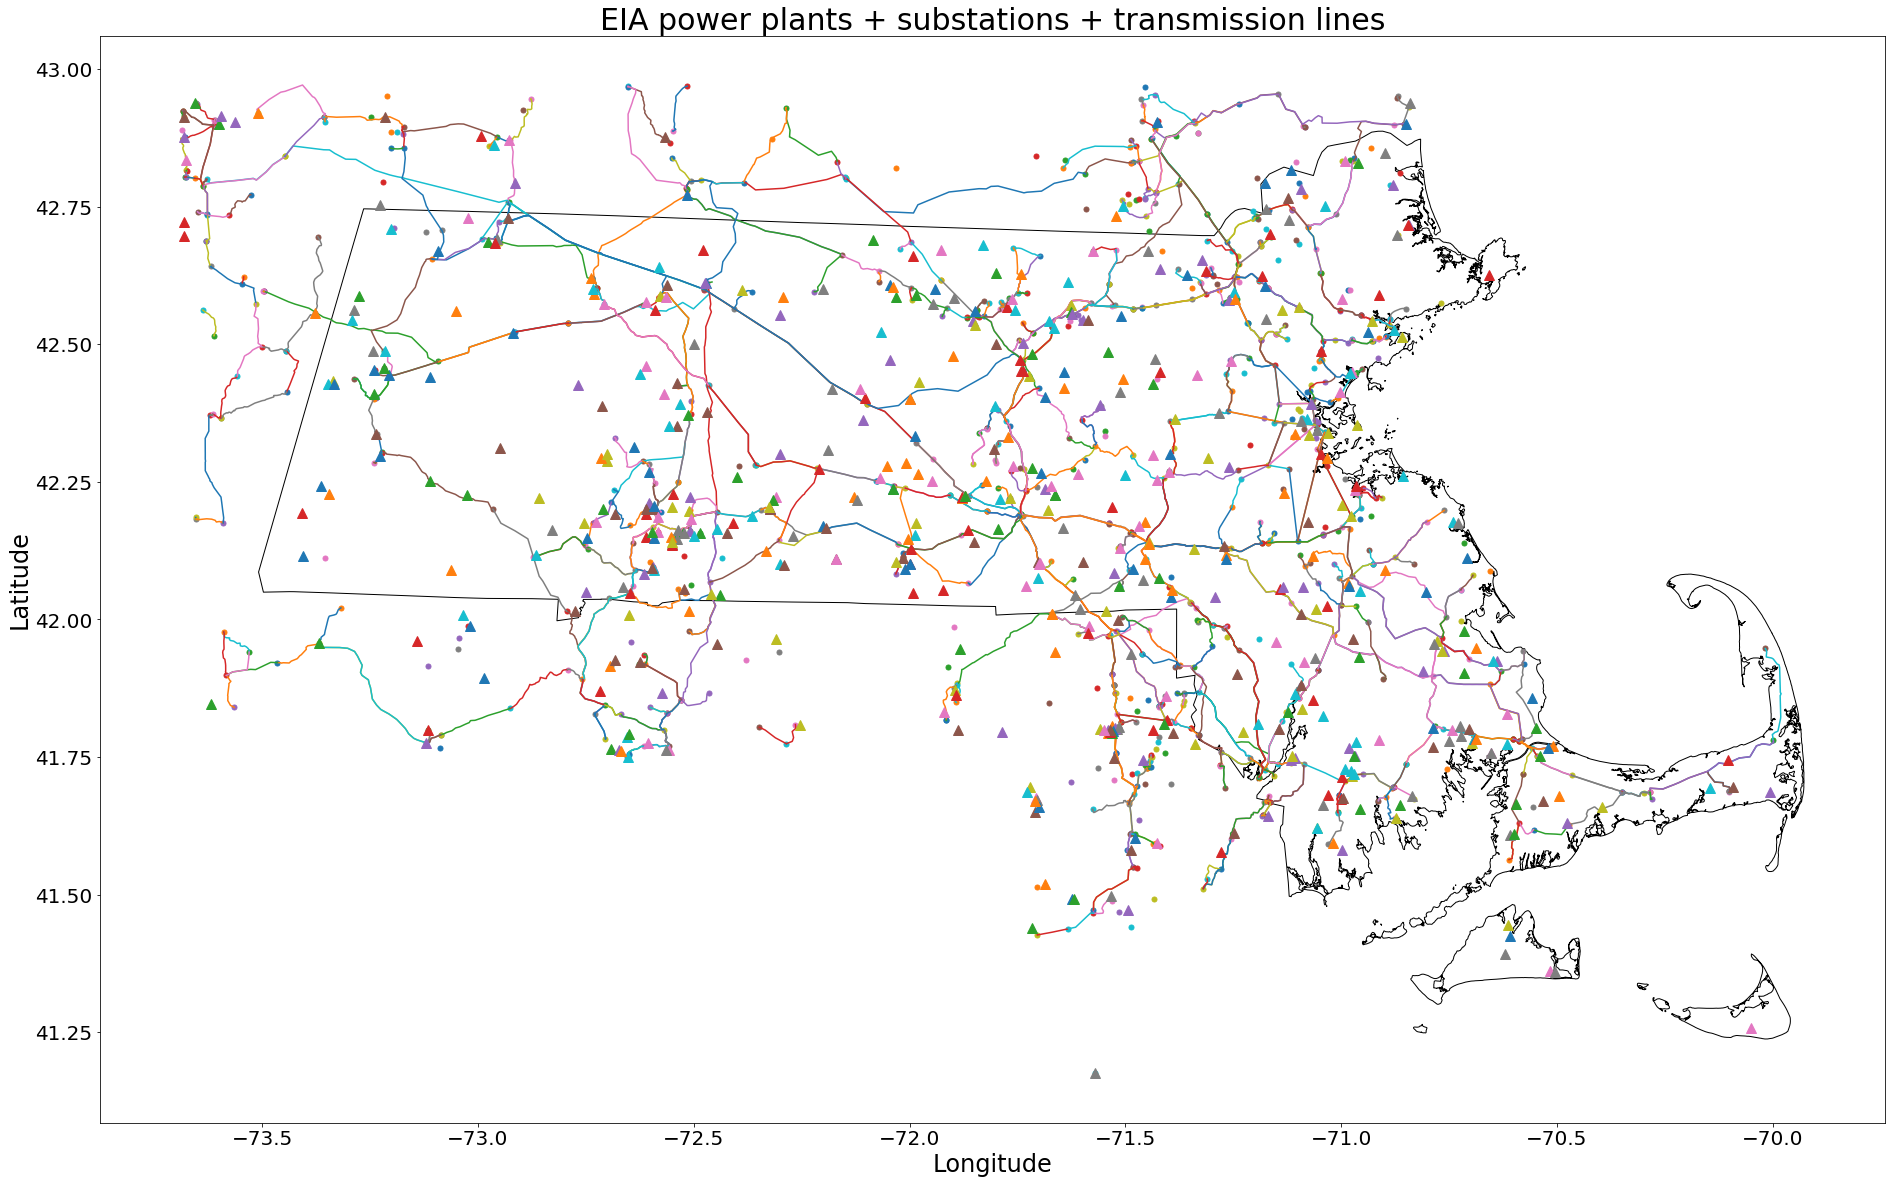

In [194]:
# Plot all the relevant substations with the power lines and substations
plt.figure(figsize=(32,20))
for shape in mass_shapes:
    for polygon in find_and_convert_polygons(shape):
        x,y = polygon.exterior.xy
        plt.plot(x, y, 'black', linewidth=1)
for i, shape in enumerate(eia_substation_shapes):
    if i in substation_indices:
        plt.plot(*zip(*[transformer_eia_substations.transform(*point) for point in shape.points]), '.', markersize=10)
for i, shape in enumerate(eia_power_shapes):
    if i in mass_indices:
        plt.plot(*zip(*[transformer_eia_power.transform(*point) for point in shape.points]))
for i, shape in enumerate(eia_plant_shapes):
    if i in plant_indices:
        plt.plot(*zip(*[transformer_eia_plants.transform(*point) for point in shape.points]), '^', markersize=10)
plt.title("EIA power plants + substations + transmission lines", fontsize=30);
plt.xticks(fontsize=20);
plt.xlabel("Longitude", fontsize=24);
plt.yticks(fontsize=20);
plt.ylabel("Latitude", fontsize=24);
plt.savefig("./plots/eia_all.png", bbox_inches="tight")

# Future Work: Construct Graph
We'll construct a graph using the `NetworkX` package.

In [167]:
len(substation_indices)

931

In [169]:
len(mass_indices)

1139

In [170]:
len(plant_indices)

538

We'll model our network as a flow graph, where sources are our power generation (triangles), edges are our power lines, and sinks are our substations (circles). The magnitude of the sources will be the power generation of the plants; the magnitude of the edges will be the voltages of the transmission lines; the magnitude of each substation is the population of the zip code divided by the number of substations in that zip code (most of the time 1).

The main difficulties associated with constructing this graph are all geometric in nature. How do we correctly assign nodes and edges? How do we deal with points that are "off-grid"? How do we deal with intersecting power lines? How do we account for the broad swaths of Massachusetts that our power line dataset doesn't cover? How do we account for our different units (Megawatt power generated, Voltage on the lines, and population at the sinks).

# Future Work: Analyze network vulnerability
Naively, one way to test this network's vulnerability is to use Monte Carlo methods to randomly remove power plants/transmission lines, and evaluate the load on the network. 

See also:
[Cascading Failures in Power Grids –Analysis and Algorithms](https://wimnet.ee.columbia.edu/wp-content/uploads/2014/04/cascades_power_eenergy.pdf)

[Joint Cyber and Physical Attacks on Power Grids:Graph Theoretical Approaches for Information Recovery](https://wimnet.ee.columbia.edu/wp-content/uploads/2015/03/Cyber-Physical-Attacks-Grid-Sigmerics15.pdf)

# Further Work: Time-dependent energy production/consumption:



Some of our power generation is from solar or wind, which varies as a function of time. How does our network adjust to these variable sources, if at all? How does this affect the robustness of the network?